# 3. Classification

In this section we will 
- train one or more classifiers
- evaluate their performance
- fine tune their hyperparameters
- save the classifier for future use

## Load utilities and programming set up

Let's start by loading the useful libraries and retrieving the train and test sets from the previous steps.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X_train = np.load("X_train_step1.pickle.npy", allow_pickle=True)
y_train = np.load("y_train_step1.pickle.npy", allow_pickle=True)

X_test = np.load("X_test_step1.pickle.npy", allow_pickle=True)
y_test = np.load("y_test_step1.pickle.npy", allow_pickle=True)

In [3]:
# Load features
import pickle
with open('features.pickle', 'rb') as f:
    features = pickle.load(f)

# Choose and train an ML model

Let us start with the Random Forest Classifier.

In [4]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25,
                                random_state=1,
                                n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=25, n_jobs=-1, random_state=1)

In [5]:
y_pred = forest.predict(X_test)

In [6]:
(y_pred == y_test).sum() / len(y_test)

0.9595261599210266

In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(forest, X_train, y_train, cv=3, scoring='accuracy')

array([0.95668271, 0.95888889, 0.95592593])

In [8]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(forest, X_train, y_train, cv=3)

In [9]:
y_train_pred.shape

(8101,)

Above we may have impression the classifier performs very well, resulting in 96% accuracy.
However, we must remember that the churning clients are minority, therefore it is important to inspect, e.g. how they are classified.
To this end, let us build the confusion matrix.

In [10]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[6704,   95],
       [ 252, 1050]])

- 6706 true negatives ($TN$) (i.e. active clients classified correctly)
- 93 false positives ($FP$) (i.e. active clients misclassified as attrited)
- 251 false negatives ($FN$) (i.e. attrited clients misclassified as active)
- 1051 true positives ($TP$) (i.e. attrited clients classified correctly)

The confusion matrix allows us to measure two interesting metrics:
- **precision**, i.e. $\frac{TP}{TP+FP}$
- **recall** (_sensitivity_), i.e. $\frac{TP}{TP+FN}$

We may compute them using the `sklearn` functions.

In [11]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train, y_train_pred)

0.9170305676855895

In [12]:
1051/(1051+93)

0.9187062937062938

In [13]:
recall_score(y_train, y_train_pred)

0.8064516129032258

In [14]:
1051/(1051+251)

0.8072196620583717

Another useful metric is the $F_1$-score, defined as a harmonic mean of precision and recall.
It is sensitive to low values and is a good way to have a single metric that expresses the both aspects.

In [15]:
from sklearn.metrics import f1_score
f1_score(y_train, y_train_pred)

0.8581937065794851

$F_1$ favours classifiers that have similar precision and recall, which might be not ideal.
If the bank wants to catch as many clients that would churn, then high recall is more important.

Let's try to tinker with the classifier threshold.

In [16]:
# BELOW DOESN'T WORK FOR RANDOM FORESTS!!! BUT SHOULD WORK FOR OTHER CLASSIFIERS
# Return decision function score rather than class
# y_scores = cross_val_predict(forest, X_train, y_train, cv=3, method="decision_function")
# from sklearn.metrics import precision_recall_curve
# precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

# def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
#     plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
#     plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
#     plt.legend()
    
# plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
# plt.show()
y_probas_forest = cross_val_predict(forest, X_train, y_train, cv=3,
                                    method="predict_proba")

In [17]:
y_scores_forest = y_probas_forest[:,1] # positive class (2nd column) probability

In [18]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thls = precision_recall_curve(y_train, y_scores_forest)

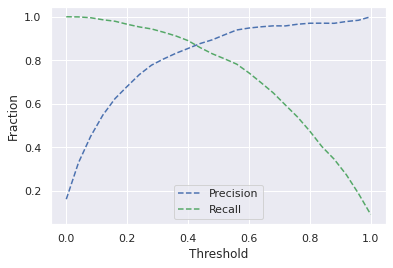

In [19]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.legend()
    plt.xlabel("Threshold")
    plt.ylabel("Fraction")
    #plt.grid()
plot_precision_recall_vs_threshold(precisions, recalls, thls)
plt.show()

In [20]:
np.argmax(recalls < 0.90)

10

In [21]:
# Find threshold for recall 90%
threshold_40_recall = thls[np.argmax(recalls < 0.90)] # NB. recalls are decreasing, hence < operator
print("Threshold with 90% recall: ", threshold_40_recall)
print("=> Precision: %.2f" % precisions[np.argmax(recalls < 0.90)])

Threshold with 90% recall:  0.4
=> Precision: 0.85


In [22]:
from sklearn.metrics import roc_curve
fpr_forest, tpr_forest, thl_forest = roc_curve(y_train, y_scores_forest)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--', label="coin toss") # Dashed diagonal
    if label:
        plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

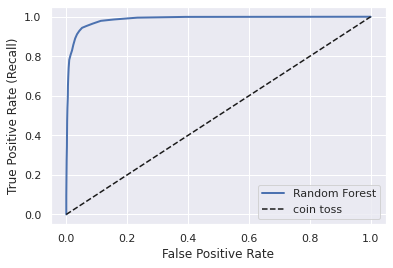

In [23]:
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.show()

In [24]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_probas_forest[:,1])

0.9862562805725699

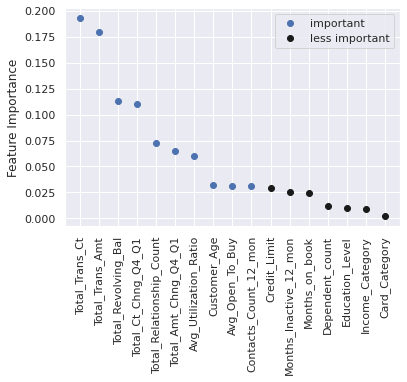

In [25]:
def plot_feature_importances(features, feature_importances, hilight_n=None):
    features_importances_sorted = sorted(zip(features, feature_importances), key = lambda x: x[1], reverse=True)
    x_sort = [x[0] for x in features_importances_sorted]
    y_sort = [x[1] for x in features_importances_sorted]
    if hilight_n:
        plt.plot(x_sort[:hilight_n], y_sort[:hilight_n], 'bo', label='important')
        plt.plot(x_sort[hilight_n:], y_sort[hilight_n:], 'ko', label='less important')
        plt.legend()
    else:
        plt.plot(x_sort, y_sort, 'bo')
    plt.xticks(rotation=90)
    plt.ylabel("Feature Importance")
    plt.show()
plot_feature_importances(features, forest.feature_importances_, hilight_n=10)

Interestingly, 'Months_Inactive_12_mon' does not appear important, while this feature exhibited significant discrimination between the two classes of clients. Perhaps its correlations with other features are exploited.
In particular, 'Months_Inactive_12_mon' shows 4-5% correlation with these *important* features: 'Total_Revolving_Bal', 'Customer_Age', 'Total_Ct_Chng_Q4_Q1', 'Total_Trans_Ct'.

<!-- [('Months_Inactive_12_mon', 1.0),
 ('Label', 0.15793696785340214),
 ('Months_on_book', 0.06778280864202155),
 ('Total_Revolving_Bal', -0.05131968994014064),
 ('Customer_Age', 0.05051876230199617),
 ('Total_Ct_Chng_Q4_Q1', -0.04867128305295917),
 ('Total_Trans_Ct', -0.04252991362358253)] -->

## Optimise Random Forests

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [1000, 1200, 1400],
     'max_features': [8, 10, 12]},
]
grid_search = GridSearchCV(forest, param_grid, cv=3,
                           scoring='f1', # maximise F1 score
                           return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_estimators=25, n_jobs=-1,
                                              random_state=1),
             n_jobs=-1,
             param_grid=[{'max_features': [8, 10, 12],
                          'n_estimators': [1000, 1200, 1400]}],
             return_train_score=True, scoring='f1')

In [27]:
grid_search.best_params_

{'max_features': 10, 'n_estimators': 1200}

In [28]:
grid_search.best_estimator_

RandomForestClassifier(max_features=10, n_estimators=1200, n_jobs=-1,
                       random_state=1)

In [29]:
cvres = grid_search.cv_results_
for f1_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(f1_score, params)

0.884146319838598 {'max_features': 8, 'n_estimators': 1000}
0.885026221930297 {'max_features': 8, 'n_estimators': 1200}
0.884231855469658 {'max_features': 8, 'n_estimators': 1400}
0.8853048904135333 {'max_features': 10, 'n_estimators': 1000}
0.8886825185796825 {'max_features': 10, 'n_estimators': 1200}
0.8883253233276777 {'max_features': 10, 'n_estimators': 1400}
0.8876367562711266 {'max_features': 12, 'n_estimators': 1000}
0.8878975465265301 {'max_features': 12, 'n_estimators': 1200}
0.8877975679518674 {'max_features': 12, 'n_estimators': 1400}


In [30]:
feature_importances = grid_search.best_estimator_.feature_importances_
MAX_FEATURES = grid_search.best_estimator_.max_features

Total_Trans_Ct 0.23284182563180245
Total_Trans_Amt 0.17669900797720323
Total_Revolving_Bal 0.14730164943061813
Total_Ct_Chng_Q4_Q1 0.10620744019594468
Total_Relationship_Count 0.08951178718826887
Total_Amt_Chng_Q4_Q1 0.05776465081392322
Avg_Utilization_Ratio 0.042647372322233486
Customer_Age 0.03067941208069235
Avg_Open_To_Buy 0.020682045263021837
Contacts_Count_12_mon 0.02020937828358816
Credit_Limit 0.018330180935261675
Months_Inactive_12_mon 0.01801007140721686
Months_on_book 0.01726312627023116
Dependent_count 0.007991740969757114
Education_Level 0.006547265060312053
Income_Category 0.005495856588628421
Card_Category 0.0018171895812962714


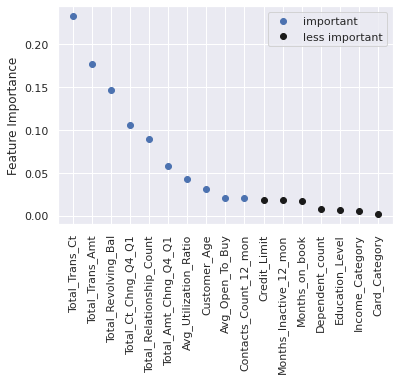

Selected features: ['Total_Trans_Ct', 'Total_Trans_Amt', 'Total_Revolving_Bal', 'Total_Ct_Chng_Q4_Q1', 'Total_Relationship_Count', 'Total_Amt_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Customer_Age', 'Avg_Open_To_Buy', 'Contacts_Count_12_mon']


In [31]:
selected_features = []
for f,i in sorted(zip(features, feature_importances), key = lambda x: x[1], reverse=True):
    print(f, i)
    if len(selected_features) < MAX_FEATURES:
        selected_features.append(f)
plot_feature_importances(features, feature_importances, hilight_n=MAX_FEATURES)
print("Selected features:", selected_features)

In [32]:
# Let's make sure the best estimator is compatible with the one trained from scratch accordingly
indexes = [features.index(f) for f in selected_features]
X_train_selected = np.take(X_train, indexes, axis=1)
clf_check = RandomForestClassifier(criterion='gini',
                                   n_estimators=1200,
                                   random_state=1,
                                   n_jobs=-1)
clf_check.fit(X_train_selected, y_train)
#X_train_selected.shape

RandomForestClassifier(n_estimators=1200, n_jobs=-1, random_state=1)

In [33]:
y_train_pred = cross_val_predict(clf_check, X_train, y_train, cv=3)
from sklearn.metrics import f1_score
score_check = f1_score(y_train, y_train_pred)
score_check

0.8702415063446582

## Evaluate the model on the Test Set

In [34]:
final_model = grid_search.best_estimator_
y_test_predict = final_model.predict(X_test)
X_test_check = np.take(X_test, indexes, axis=1)
y_test_predict_check = clf_check.predict(np.take(X_test, indexes, axis=1))
y_test_predict_proba = final_model.predict_proba(X_test)
# pipeline needed

In [35]:
precision_score(y_test, y_test_predict)


0.912751677852349

In [36]:
precision_score(y_test, y_test_predict_check)


0.9146757679180887

In [37]:
recall_score(y_test, y_test_predict)

0.8369230769230769

In [38]:
from sklearn.metrics import f1_score
f1_score(y_test, y_test_predict)

0.8731942215088283

In [39]:
# Using threshold
y_test_predict_proba[:,1] > 0.4

array([False, False,  True, ...,  True, False, False])

In [40]:
precisions, recalls, thls = precision_recall_curve(y_test, y_test_predict_proba[:,1])

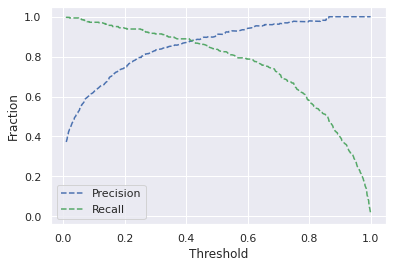

Recall at 40% threshold: 0.8892307692307693
Precision at 40% threshold: 0.8731117824773413


In [41]:
plot_precision_recall_vs_threshold(precisions, recalls, thls)
plt.show()
print("Recall at 40% threshold:", recalls[np.argmax(thls >= 0.4)])
print("Precision at 40% threshold:", precisions[np.argmax(thls >= 0.4)])

In [42]:
class FlexibleThresholdClassifier(object):
    """Wrapper of the scikit-learn classifier that allows to specify the threshold `thl`.
    The default `thl` value of 0.5 corresponds to the default prediction as with 
    `final_model.predict(X)`. Providing a different value shifts the recall vs. precision working point:
    - thl > 0.5 => greater precision, smaller recall
    - thl < 0.5 => smaller precision, greater recall"""
    def __init__(self, classifier, thl=0.5):
        self.classifier = classifier
        self.thl = thl
    def predict(self, X):
        return np.where(self.predict_proba(X)[:,1] > self.thl, 1, 0)
    def predict_proba(self, X):
        return self.classifier.predict_proba(X)


In [43]:
myModel = FlexibleThresholdClassifier(clf_check, thl=0.4)


In [44]:
myModel.predict(X_test_check)

array([0, 0, 1, ..., 1, 0, 0])

## Save classifier for future use

In [45]:
with open("classifier.pickle", 'wb') as f:
    pickle.dump(myModel, f)

In [46]:
# Save feature names
with open("selected_features.txt", 'w') as f:
    for feature in selected_features:
        f.write(feature + "\n")

In [47]:
%cat selected_features.txt

Total_Trans_Ct
Total_Trans_Amt
Total_Revolving_Bal
Total_Ct_Chng_Q4_Q1
Total_Relationship_Count
Total_Amt_Chng_Q4_Q1
Avg_Utilization_Ratio
Customer_Age
Avg_Open_To_Buy
Contacts_Count_12_mon


# Simulate deployment

Let us pretend we have two new clients, an active and passive ones (respectively with high and low 'Total_Trans_Ct') and let us see how the model classifies them.

In [48]:
new_client = np.array([[20, 2300, 600, 1.5, 3, 1400, 0.7, 52, 9500, 2],
                       [0, 2300, 600, 1.5, 3, 1400, 0.7, 52, 9500, 2]])

In [49]:
#myModel.predict(new_client.reshape(2,MAX_FEATURES))
myModel.predict(new_client)

array([0, 1])

It is not surprising that the first client obtained `0` class ('Active Customer') and the second one `1` class ('Attrited Customer').

# Summary
In this little project we have developed a classifier capable of detecting churning clients with **84% sensitivity** (recall) and **91% precision**. The algorithm allows for tuning the recall-precision trade-off, for example, resulting in the working point of **89% sensitivity** and **87% precision**, depending on the _threshold_ required.

This project was meant as a mostly complete end-to-end example of classification on a real-world problem.
Possible improvements might entail:
- Mitigating the imbalanced class representation
- More elaborate feature engineering (e.g. dimensionality reduction with PCA)
- Addition of other classification algorithms (e.g. SVM, KNN)
- Deployment on a web server